<a href="https://colab.research.google.com/github/SeanBarnier/HAFS_Air-Sea/blob/main/fluxes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Set up environment

In [3]:
!pip install cfgrib

In [4]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
import cfgrib

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#User parameters

In [102]:
name = "Milton"
tcNum = "14"
trackType = ""

initTime = dt(year=2024, month=10, day=7, hour=12) #Time when Milton began its most rapid intensification

fHourStep = 6       #Normally 3 for HAFS-A
forecastLength = 48 #Normally 126 for HAFS-A.
#runStep = 6         #Normally 6 for HAFS-A

figureSuffix = "_RI"
subfolder = "RI/"
dataPath = "/content/drive/MyDrive/savedData/"
figurePath = "/content/drive/MyDrive/figures/"

stormCentered = True
potentialTemp = True #Use atmospheric potential temperature instead of in-situ temperature

atmTop = 850
oceFloor = 100

Get ATCF data and find interested point

#Retrieve HAFS-A Data

Find times needed

In [103]:
dateFormat = "%Y-%m-%d %H:%M:%S"
runFormat = "%Y%m%d%H"

fcastTimes = [] #Key: initiation, item: valid time list
fhour = 0
validTime = initTime

while fhour <= forecastLength:
    fcastTimes.append(validTime)
    validTime += pd.Timedelta(hours=fHourStep)
    fhour += fHourStep

Find storm location in HAFS-A from ATCF files. Used to find along-storm profile.

In [104]:
cols = ["BASIN", "CY", "YYYYMMDDHH", "TECHNUM/MIN", "TECH", "TAU", "LatN/S", "LonE/W",
    "VMAX", "MSLP", "TY", "RAD", "WINDCODE", "RAD1", "RAD2", "RAD3", "RAD4",
    "POUTER", "ROUTER", "RMW", "GUSTS", "EYE", "SUBREGION", "MAXSEAS", "INITIALS",
    "DIR", "SPEED", "STORMNAME", "DEPTH", "SEAS", "SEASCODE", "SEAS1", "SEAS2",
    "SEAS3", "SEAS4", "USERDEFINED1", "Thermo1", "Thermo2", "Thermo3", "Thermo4",
    "Thermo5", "Thermo6", "Thermo7", "USERDEFINED2", "DT", "SHR82", "SHR81_1",
    "SHR82_2",  "USERDEFINED3", "SST", "USERDEFINED4", "ARMW1", "ARMW2"]

initStr, initHour = initTime.strftime("%Y%m%d_%H").split("_")

atcfURL = f"https://noaa-nws-hafs-pds.s3.amazonaws.com/hfsa/{initStr}/{initHour}/{tcNum}l.{initStr}{initHour}.hfsa.trak.atcfunix"
atcfFile = "atcf_" + initStr + "_" + initHour + ".csv"

!wget -O {atcfFile} {atcfURL}
atcf = pd.read_csv(atcfFile, names=cols)

--2025-07-11 21:29:03--  https://noaa-nws-hafs-pds.s3.amazonaws.com/hfsa/20241007/12/14l.2024100712.hfsa.trak.atcfunix
Resolving noaa-nws-hafs-pds.s3.amazonaws.com (noaa-nws-hafs-pds.s3.amazonaws.com)... 52.217.236.41, 3.5.27.59, 16.15.185.155, ...
Connecting to noaa-nws-hafs-pds.s3.amazonaws.com (noaa-nws-hafs-pds.s3.amazonaws.com)|52.217.236.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32918 (32K) [application/octet-stream]
Saving to: ‘atcf_20241007_12.csv’

atcf_20241007_12.cs 100%[===================>]  32.15K  --.-KB/s    in 0.02s   

2025-07-11 21:29:03 (1.77 MB/s) - ‘atcf_20241007_12.csv’ saved [32918/32918]



In [105]:
tcLocs = {}

for valid in fcastTimes:
    fHour = int((valid-initTime).total_seconds() / 3600)

    pointLat = int(atcf[atcf.TAU==fHour]["LatN/S"].iloc[0].replace("N", ""))/10
    pointLon = int(atcf[atcf.TAU==fHour]["LonE/W"].iloc[0].replace("W", ""))/-10 #Assume western hemisphere
    tcLocs[valid] = (pointLat, pointLon)

Get data from HAFS-A output.

In [106]:
fcastTimes

[datetime.datetime(2024, 10, 7, 12, 0),
 datetime.datetime(2024, 10, 7, 18, 0),
 datetime.datetime(2024, 10, 8, 0, 0),
 datetime.datetime(2024, 10, 8, 6, 0),
 datetime.datetime(2024, 10, 8, 12, 0),
 datetime.datetime(2024, 10, 8, 18, 0),
 datetime.datetime(2024, 10, 9, 0, 0),
 datetime.datetime(2024, 10, 9, 6, 0),
 datetime.datetime(2024, 10, 9, 12, 0)]

In [107]:
atm = {}

for valid in fcastTimes:

  initStr = initTime.strftime("%Y%m%d%H")

  atm[valid] = {}

  fhour = str(int((valid-initTime).total_seconds() / 3600))
  while len(fhour) < 3: fhour = "0" + fhour

  atmFile = "hafsa_" + initStr + "_f" + fhour + ".nc"
  atmPath = dataPath + "hafsaOutput/" + subfolder + atmFile
  atmData = xr.open_dataset(atmPath)

  point = tcLocs[valid]
  levels = atmData.isobaricInhPa.data[atmData.isobaricInhPa.data>atmTop] #Get lowest point; should be 1000 hPa

  #Longitude in atm files are in degrees east, but are -180 - 180 in oce files. point has them from -180 - 180
  validPoint = atmData.sel(latitude=point[0], longitude=point[1] + 360, method="nearest")
  for level in levels:
    atm[valid][level] = {}
    atm[valid][level]["T"] = float(validPoint.sel(isobaricInhPa=level).t.data)
    atm[valid][level]["q"] = float(validPoint.sel(isobaricInhPa=level).q.data) * 1000 #Convert from kg/kg to g/kg
    atm[valid][level]["u"] = float(validPoint.sel(isobaricInhPa=level).u.data)
    atm[valid][level]["v"] = float(validPoint.sel(isobaricInhPa=level).v.data)
    atm[valid][level]["gh"] = float(validPoint.sel(isobaricInhPa=level).gh.data)
    atm[valid][level]["sst"] = float(validPoint.sst.data)
    atm[valid][level]["shf"] = float(validPoint.ishf.data)
    atm[valid][level]["lhf"] = float(validPoint.slhtf.data)

/tmp/ipython-input-107-1961457510.py:14: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  atmData = xr.open_dataset(atmPath)
/tmp/ipython-input-107-1961457510.py:14: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  atmData = xr.open_dataset(atmPath)
/tmp/ipython-input-107-1961457510.py:14: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  atmData = xr.open_dataset(atmPath)
/tmp/ipython-input-107-1961457510.py:14: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set 

In [108]:
oce = {}

for valid in fcastTimes:

  fhour = str(int((valid-initTime).total_seconds() / 3600))
  while len(fhour) < 3: fhour = "0" + fhour
  oceFile = "mom6_" + initStr + "_f" + fhour + ".nc"
  ocePath = dataPath + "mom6Output/" + subfolder + oceFile

  if oceFile == 'mom6_2024100800_f000.nc': #This file is missing
    for layer in oceData.z_l.data:
      oce[initTime][valid][layer] = {"T":np.nan, "s":np.nan, "u":np.nan, "v":np.nan}
    continue

  oceData = xr.open_dataset(ocePath, decode_times=False)

  point = tcLocs[valid]
  levels = oceData.z_l.data[oceData.z_l.data<=oceFloor] #Retrieves most shallow layer; should be 1 m

  oce[valid] = {}

  for level in levels:
    oce[valid][level] = {}
    oce[valid][level]["T"] = float(oceData.sel(yh=point[0], xh=point[1], z_l=level, method="nearest").temp.data) + 273.15 #This is potential temperature. Converted from C to K.
    oce[valid][level]["s"] = float(oceData.sel(yh=point[0], xh=point[1], z_l=level, method="nearest").so.data)
    oce[valid][level]["u"] = float(oceData.sel(yh=point[0], xq=point[1], z_l=level, method="nearest").uo.data)
    oce[valid][level]["v"] = float(oceData.sel(yq=point[0], xh=point[1], z_l=level, method="nearest").vo.data)
    oce[valid][level]["sst"] = float(oceData.sel(yh=point[0], xh=point[1], method="nearest").SST.data) + 273.15
    oce[valid][level]["ssh"] = float(oceData.sel(yh=point[0], xh=point[1], method="nearest").SSH.data)
    oce[valid][level]["shf"] = float(oceData.sel(yh=point[0], xh=point[1], method="nearest").sensible.data)
    oce[valid][level]["lhf"] = float(oceData.sel(yh=point[0], xh=point[1], method="nearest").latent.data)

/tmp/ipython-input-108-258487536.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  oce[valid][level]["T"] = float(oceData.sel(yh=point[0], xh=point[1], z_l=level, method="nearest").temp.data) + 273.15 #This is potential temperature. Converted from C to K.
/tmp/ipython-input-108-258487536.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  oce[valid][level]["s"] = float(oceData.sel(yh=point[0], xh=point[1], z_l=level, method="nearest").so.data)
/tmp/ipython-input-108-258487536.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from you

#Figures

Goal: Correlate atmospheric sensible and latent heat flues and momentum fluxes with intensity forecasts and error across runs.  
Particularly, look at the wind-caused and current-caused momentum flux.

Text(0.5, 0.98, 'Correlation = 0.6075108148869421')

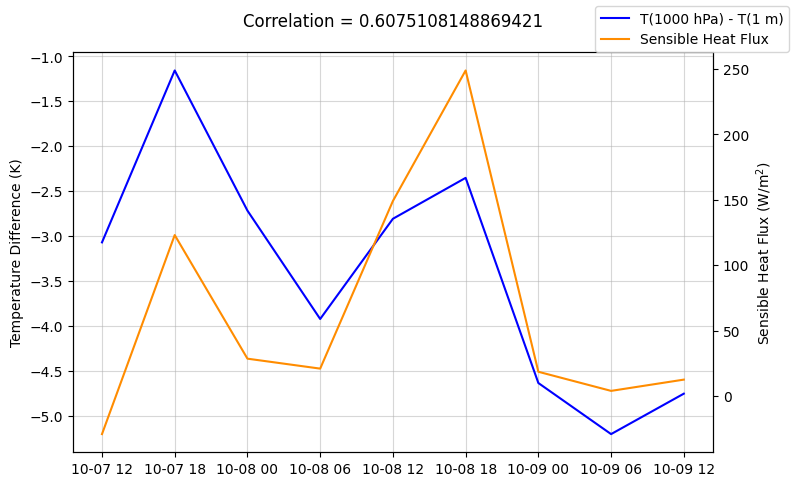

In [110]:
fluxFig = plt.figure(figsize=(8,5))
tAx = fluxFig.add_axes([0.1,0.1,0.8,0.8])
shfAx = tAx.twinx()

tDiff = [oce[valid][1.0]["T"] - atm[valid][1000.0]["T"] for valid in atm.keys()]
shf = [atm[valid][1000.0]["shf"] for valid in atm.keys()]
tAx.plot(atm.keys(), tDiff, label="T(1000 hPa) - T(1 m)", color="blue")
shfAx.plot(atm.keys(), shf, label="Sensible Heat Flux", color="darkorange")

fluxFig.legend()
tAx.grid(alpha=0.5)
tAx.set_ylabel("Temperature Difference (K)")
shfAx.set_ylabel("Sensible Heat Flux (W/m" + "$^2$" + ")")
#lhfAx.set_ylabel("Latent Heat Flux (W/m^2)")

fluxFig.suptitle(f"Correlation = {str(np.corrcoef(tDiff, shf)[0,1])}")

Text(0.5, 0.98, 'Correlation = 0.6748494042974532')

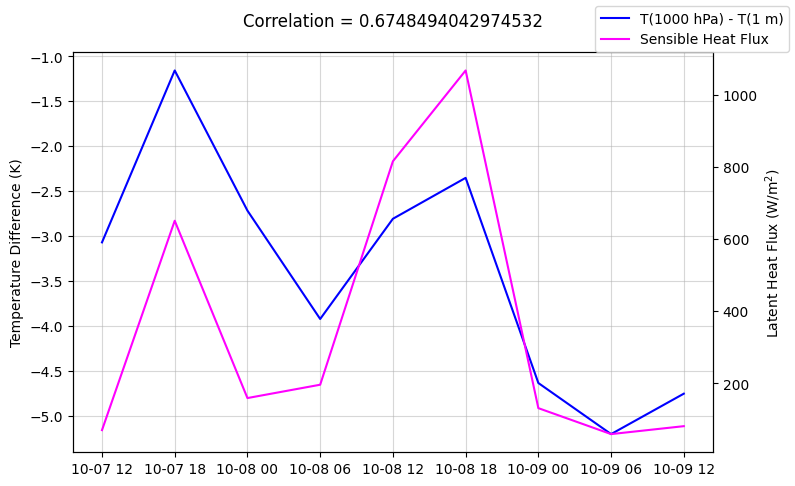

In [111]:
fluxFig = plt.figure(figsize=(8,5))
tAx = fluxFig.add_axes([0.1,0.1,0.8,0.8])
lhfAx = tAx.twinx()

tDiff = [oce[valid][1.0]["T"] - atm[valid][1000.0]["T"] for valid in atm.keys()]
lhf = [atm[valid][1000.0]["lhf"] for valid in atm.keys()]
tAx.plot(atm.keys(), tDiff, label="T(1000 hPa) - T(1 m)", color="blue")
lhfAx.plot(atm.keys(), lhf, label="Sensible Heat Flux", color="magenta")

fluxFig.legend()
tAx.grid(alpha=0.5)
tAx.set_ylabel("Temperature Difference (K)")
lhfAx.set_ylabel("Latent Heat Flux (W/m" + "$^2$" + ")")
#lhfAx.set_ylabel("Latent Heat Flux (W/m^2)")

fluxFig.suptitle(f"Correlation = {str(np.corrcoef(tDiff, lhf)[0,1])}")

Profiles and SST

In [112]:
xwidth = (0.7/len(atm.keys()))
xcorners = np.arange(0.1, 0.9, 0.8/len(atm.keys()))

Text(0.02, 0.5, 'Pressure (hPa)')

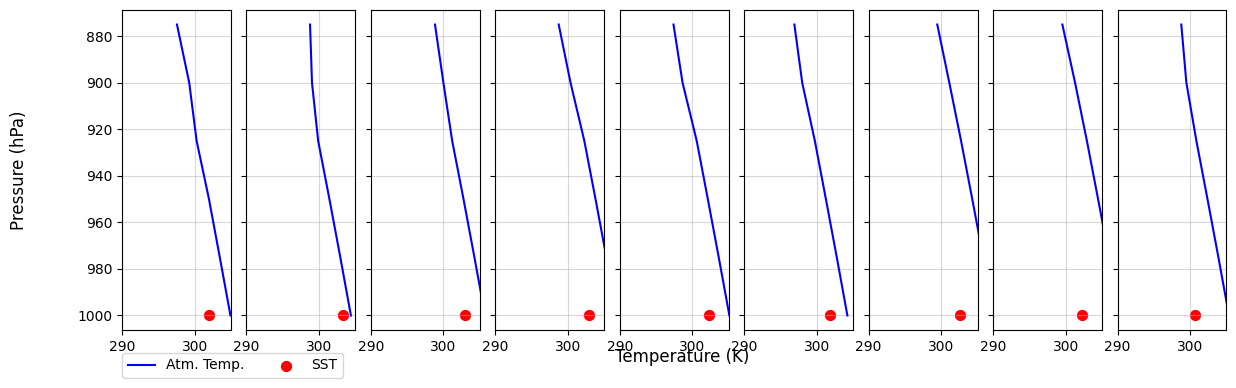

In [114]:
profFig = plt.figure(figsize=(14,4))
profAxes = [profFig.add_axes([xcorner,0.1,xwidth,0.8]) for xcorner in xcorners]

for ax, valid in zip(profAxes, atm.keys()):
  t = [atm[valid][level]["T"] for level in atm[valid].keys()]
  p = atm[valid].keys()
  ax.plot(t, p, color="blue", label="Atm. Temp.")
  ax.scatter(atm[valid][1000.0]["sst"], 1000, color="red", s=50, label="SST")

  ax.set_xlim(290, 305)
  ax.invert_yaxis()
  grid = ax.grid(alpha=0.5)

  if valid == fcastTimes[0]: ax.legend(ncols=2, loc=(0, -0.15))
  else: ax.set_yticklabels([])

profFig.supxlabel("Temperature (K)")
profFig.supylabel("Pressure (hPa)")